In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy.spatial.transform import Rotation as R
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [2]:
SOURCE_H5_PATH = "../dataset.h5"
DATASET_PATH = "../target-pose-dataset.h5"
INTRINSICS = {"focalLength": 1.0, "width": 420.0, "height": 360.0, "zRange": [0.01, 2.0]}

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:2


In [3]:
def move_to_device(batch: tuple[torch.Tensor, ...]):
    return tuple(item.to(device, non_blocking=True) for item in batch)

In [4]:
def quat_to_matrix(quaternions: np.typing.ArrayLike):
    return R.from_quat(np.roll(quaternions, -1, axis=-1)).as_matrix()


def project_points(world_point, cam_poses):
    cam_positions = cam_poses[:, :3]
    cam_quaternions = cam_poses[:, 3:]

    rots = quat_to_matrix(cam_quaternions)

    points_rel = world_point[None, :] - cam_positions
    p_cam = np.einsum("nij,nj->ni", rots.transpose(0, 2, 1), points_rel)

    f, w, h = (INTRINSICS["focalLength"], INTRINSICS["width"], INTRINSICS["height"])
    u = (f * p_cam[:, 0] / p_cam[:, 2]) * (w / 2) + w / 2
    v = (f * p_cam[:, 1] / p_cam[:, 2]) * (h / 2) + h / 2
    return np.stack([u, v], axis=1)


def make_gaussian_maps(centers, sigma=8):
    width, height = int(INTRINSICS["width"]), int(INTRINSICS["height"])
    X, Y = np.meshgrid(np.arange(width), np.arange(height))
    u = centers[:, 0, None, None]
    v = centers[:, 1, None, None]

    g = np.exp(-((X - u) ** 2 + (Y - v) ** 2) / (2 * sigma**2))
    g /= g.max(axis=(1, 2), keepdims=True) + 1e-8
    return g.astype(np.float32)

In [5]:
with h5py.File(SOURCE_H5_PATH, "r") as f_in, h5py.File(DATASET_PATH, "w") as f_out:
    f_out.attrs.update(f_in.attrs)

    for dp_key in tqdm(f_in.keys(), desc="Processing scenes"):
        dp = f_in[dp_key]

        depths = dp["depths"][()]
        cam_poses = dp["cam_poses"][()]
        seg_ids = dp["seg_ids"][()]
        obj_ids = dp["obj_ids"][()]
        poses = dp["poses"][()]

        for oi in range(poses.shape[0]):
            target_pos = dp["target_poses"][oi][:3]

            centers = project_points(target_pos, cam_poses)
            goal_maps = make_gaussian_maps(centers, sigma=6)

            dp_group = f_out.create_group(f"{dp_key}_obj_{oi}")
            dp_group.create_dataset("depths", data=depths)
            dp_group.create_dataset("masks", data=(seg_ids == obj_ids[oi]).astype(np.float32))
            dp_group.create_dataset("goal_maps", data=goal_maps)
            dp_group.create_dataset("target_pos", data=target_pos)

Processing scenes: 100%|██████████| 1300/1300 [01:27<00:00, 14.94it/s]


In [6]:
class TargetPosDataset(Dataset):
    def __init__(self):
        self._h5_file = None

        with h5py.File(DATASET_PATH, "r") as f:
            self.keys = list(f.keys())

    def _init_h5(self):
        if self._h5_file is None:
            self._h5_file = h5py.File(DATASET_PATH, "r")

    def close(self):
        if self._h5_file is not None:
            self._h5_file.close()
            self._h5_file = None

    def __del__(self):
        self.close()

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        self._init_h5()
        dp = self._h5_file[self.keys[idx]]
        return (dp["depths"][()], dp["masks"][()], dp["goal_maps"][()], dp["target_pos"][()])

In [7]:
dataset = TargetPosDataset()
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
print(len(dataset))

5943


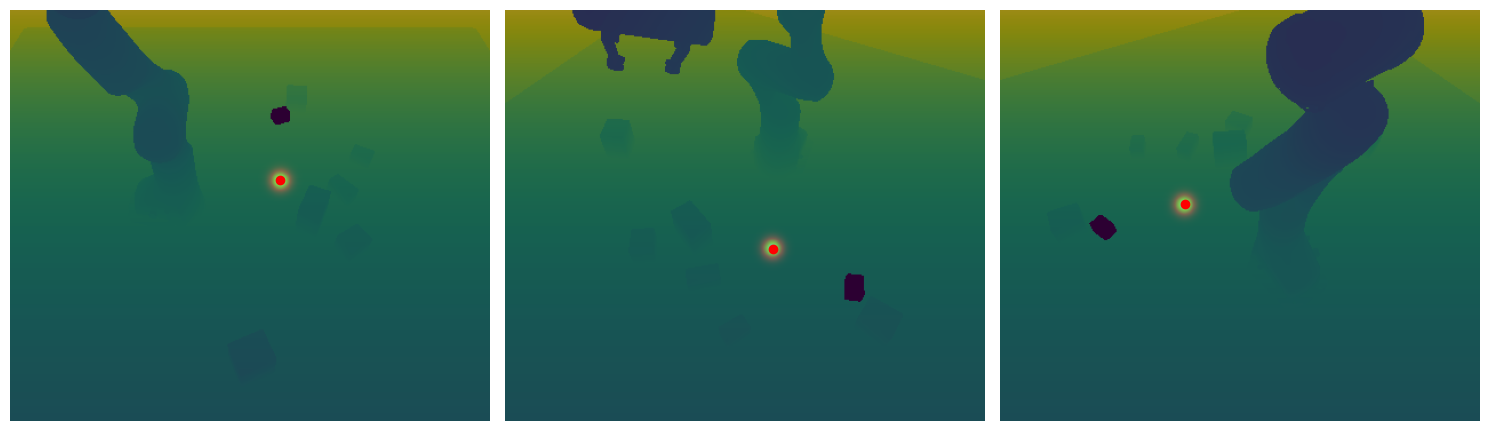

In [8]:
depths, masks, goals, _ = dataset[0]
num_views = depths.shape[0]

_, axes2 = plt.subplots(1, num_views, figsize=(5 * num_views, 5), squeeze=False)
for vi in range(num_views):
    depth = depths[vi]
    depth[masks[vi] == 1.0] = 0.0
    goal = goals[vi]
    target_v, target_u = np.unravel_index(np.argmax(goal), goal.shape)

    ax = axes2[0, vi]
    ax.imshow(depth, cmap="viridis")
    ax.imshow(goal, cmap="hot", alpha=0.4)
    ax.scatter([target_u], [target_v], color="red")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [9]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 3, stride: int = 1, padding: int = 1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))


class MLPBlock(nn.Module):
    def __init__(self, in_features: int, out_features: int, dropout: float = 0.2):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout(self.relu(self.linear(x)))


class TargetPosNet(nn.Module):
    def __init__(self, num_views: int = 3):
        super().__init__()
        self.num_views = num_views

        in_channels = 3  # depth, mask, goal
        self.feature_extractor = nn.Sequential(
            ConvBlock(in_channels, 32, stride=2),
            ConvBlock(32, 64, stride=1),
            ConvBlock(64, 64, stride=2),
            ConvBlock(64, 128, stride=1),
            ConvBlock(128, 128, stride=2),
            ConvBlock(128, 256, stride=1),
        )

        self.spatial_pool = nn.AdaptiveAvgPool2d((7, 6))

        self.fusion_conv = nn.Sequential(
            ConvBlock(256 * num_views, 512),
            ConvBlock(512, 256),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
        )

        self.mlp = nn.Sequential(
            MLPBlock(256, 512),
            MLPBlock(512, 256),
            nn.Linear(256, 3),
        )

    def forward(self, depths, masks, goals):
        per_view_features = []
        for v in range(self.num_views):
            x = torch.stack([depths[:, v], masks[:, v], goals[:, v]], dim=1)
            features = self.feature_extractor(x)
            features = self.spatial_pool(features)
            per_view_features.append(features)

        multi_view = torch.cat(per_view_features, dim=1)
        fused = self.fusion_conv(multi_view)
        out = self.mlp(fused)
        return out

In [10]:
model = TargetPosNet(num_views=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3)
mse_loss = nn.MSELoss()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

5558851


In [11]:
train_losses = []
val_losses = []

for epoch in range(10):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        depths, masks, goals, target_pos = move_to_device(batch)

        optimizer.zero_grad()
        pred = model(depths, masks, goals)
        loss = mse_loss(pred, target_pos)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * depths.size(0)
    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            depths, masks, goals, target_pos = move_to_device(batch)
            pred = model(depths, masks, goals)
            val_loss += mse_loss(pred, target_pos).item() * depths.size(0)
    val_loss /= len(test_dataset)
    val_losses.append(val_loss)

    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]["lr"]
    print(f"epoch {epoch + 1:02d}, train_loss={train_loss:.6f}, val_loss={val_loss:.6f}, lr={current_lr:.2e}")

epoch 01, train_loss=0.006520, val_loss=0.000700, lr=1.00e-03
epoch 02, train_loss=0.002429, val_loss=0.000620, lr=1.00e-03
epoch 03, train_loss=0.001872, val_loss=0.001467, lr=1.00e-03
epoch 04, train_loss=0.001893, val_loss=0.000548, lr=1.00e-03
epoch 05, train_loss=0.001440, val_loss=0.000634, lr=1.00e-03
epoch 06, train_loss=0.001265, val_loss=0.000300, lr=1.00e-03
epoch 07, train_loss=0.001096, val_loss=0.000426, lr=1.00e-03
epoch 08, train_loss=0.001079, val_loss=0.000479, lr=1.00e-03
epoch 09, train_loss=0.000909, val_loss=0.000738, lr=1.00e-03
epoch 10, train_loss=0.000981, val_loss=0.000379, lr=5.00e-04


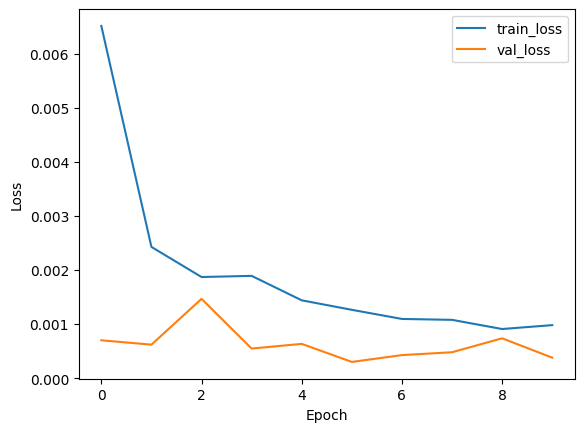

In [12]:
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [13]:
model.eval()
with torch.no_grad():
    depth, mask, goal, target_pos = move_to_device(next(iter(test_loader)))
    pred = model(depth, mask, goal)

    i = 4
    t = target_pos[i].detach().cpu().numpy()
    p = pred[i].detach().cpu().numpy()
    print(f"target_pos = {t}")
    print(f"predicted  = {p}")
    print(f"diff (L2)  = {np.linalg.norm(p - t):.4f}")

target_pos = [-0.38026714  0.4883186   0.08627261]
predicted  = [-0.43910703  0.48523137  0.09434509]
diff (L2)  = 0.0595
